# WRF Forecast to Power Tutorial

This tutorial will walk through the process of going from a WRF forecast model data to AC power using the SAPM.

Table of contents:
1. [Setup](#Setup)
2. [Load Forecast Data](#Load-Forecast-Data)
2. [Pull a location from NY-Sun Database and extract meteorological data](#Pull-a-location-from-NY-Sun-Database-and-extract-meteorological-data)
2. [Module-Specific Power Calculation](#Module-Specific-Power-Calculationn)
2. [Nameplate Capacity-Based Power Calculation](#Nameplate-Capacity-Based-Power-Calculation)

This tutorial requires pvlib from [my GitHub repo](https://github.com/jeffreysward/pvlib-python)!

Authors:
* Jeffrey Sward (jas983@cornell.edu), Cornell University, November 2020

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# built in python modules
import datetime
import os
import inspect
import sys

# python add-ons
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import wrf
from optwrf import runwrf as rw
from optwrf import postwrf as pw
from optwrf import util

# Import the pvlib module
import pvlib
from pvlib.wrfcast import WRF
from pvlib.location import Location
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.modelchain import ModelChain

No module named 'pyresample'


## Load Forecast Data

In [2]:
# Specify the forecast model as WRF
fm = WRF()

In [4]:
# Find the absolute file path to your pvlib installation
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

# absolute path to WRF data file
DIR_WRFOUT = '/Users/jeffreysward/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/wrf_data/data/wrf/'
wrfout_file = 'wrfout_d01_2020-06-30_00:00:00'

# Get/process the data from the wrfout file
forecast_data = pw.process_wrfout_manual(DIR_WRFOUT, wrfout_file, save_file=False)

The ``xarray Dataset`` below shows which variables are included in the processed WRF data

In [5]:
forecast_data.head()

<xarray.Dataset>
Dimensions:         (south_north: 5, west_east: 5, Time: 5, bottom_top: 5)
Coordinates:
    XLONG           (south_north, west_east) float32 -83.34 -83.21 ... -82.85
    XLAT            (south_north, west_east) float32 36.88 36.89 ... 37.34 37.35
  * Time            (Time) datetime64[ns] 2020-06-30 ... 2020-06-30T04:00:00
Dimensions without coordinates: south_north, west_east, bottom_top
Data variables: (12/14)
    temp_air        (Time, south_north, west_east) float32 23.05 22.67 ... 20.25
    cloud_fraction  (Time, bottom_top, south_north, west_east) float32 0.0 .....
    cos_zenith      (Time, south_north, west_east) float32 0.0 0.0 ... -0.4212
    dni             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    dhi             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    height_agl      (Time, bottom_top, south_north, west_east) float32 10.48 ...
    ...              ...
    rel_humidity    (Time, bottom_top, south_north, west_east) float32 86.12 ...
    pressure        (Time, bottom_top, south_north, west_east) float32 946.7 ...
    geopotential    (Time, bottom_top, south_north, west_east) float32 5.893e...
    ghi             (Time, south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    wind_speed100   (Time, south_north, west_east) float32 2.439 2.229 ... 3.925
    wpd             (Time, south_north, west_east) float32 7.251e+03 ... 3.02...
Attributes: (12/139)
    FieldType:                       104
    MemoryOrder:                     XY 
    description:                     TEMP at 2 M
    units:                           K
    stagger:                         
    coordinates:                     XLONG XLAT XTIME
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [8]:
#  For now just use the winds at the lowest model level as the "10m" wind speed.
forecast_data['wind_speed'] = forecast_data.wspd.isel(bottom_top=0)

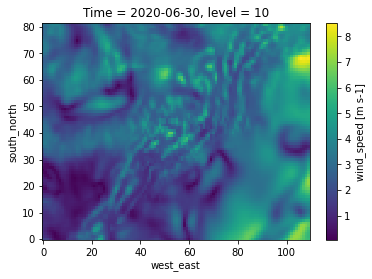

In [9]:
forecast_data.wind_speed.isel(Time=0).plot()

## Pull a location from NY-Sun Database and extract meteorological data

In [10]:
# Get location data from NY-Sun Database
location = Location(latitude=40.7484, longitude=-73.9967)
location

Location: 
  name: None
  latitude: 40.7484
  longitude: -73.9967
  altitude: 0
  tz: UTC

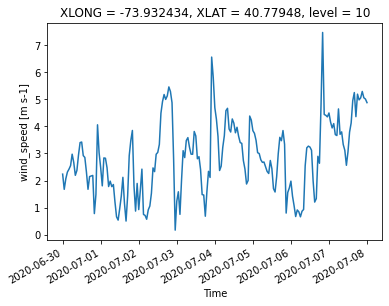

In [11]:
# Extract data for this location from the processed WRF data
# Here is a way of doing it that works well for multiple points 
# (i.e., you create a Kdtree_ll_to_xy class and query it when you need a pair of indicies)
ns = util.Kdtree_ll_to_xy(forecast_data,'XLAT','XLONG')
iy,ix = ns.query(location.latitude, location.longitude)
forecast_data.wind_speed.isel(west_east=ix, south_north=iy).plot()

In [12]:
location_forecast = forecast_data.isel(west_east=ix, south_north=iy)

In [13]:
location_forecast = location_forecast[['dni', 'dhi', 'ghi', 'temp_air', 'wind_speed']].to_dataframe()

## Module-Specific Power Calculation

In [14]:
# Specify a module/inverter pair for the PVSystem
sandia_modules = retrieve_sam('SandiaMod')
sapm_inverters = retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

In [19]:
# Specify the PVSystem (i.e., what the system looks like that we are calculating the power for)
# Perhaps we can pull this information from the NY-Sun Database at some point as well, 
# but it would certainly take a long time to process each time, 
# so I would probably need to save it to a local database.
temperature_model_parameters = (pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer'])
system = PVSystem(module_parameters=module,
                  inverter_parameters=inverter,
                  temperature_model_parameters=temperature_model_parameters, 
                  surface_tilt=location.latitude)

In [20]:
# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, location)

In [21]:
# extract relevant data for model chain
mc.run_model(location_forecast)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: sandia_inverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

/Users/jeffreysward/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python/pvlib/modelchain.py:499: pvlibDeprecationWarning: ModelChain.total_irrad is deprecated and will be removed in v0.10. Use ModelChain.results.total_irrad instead
  warnings.warn(msg, pvlibDeprecationWarning)


<AxesSubplot:xlabel='Time'>

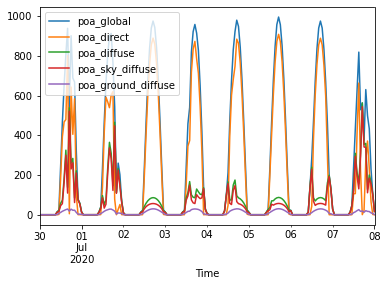

In [22]:
# This plot shows the irradiance (I assume the y-axis units are W/m^2, but I'm not sure).
mc.total_irrad.plot()

/Users/jeffreysward/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python/pvlib/modelchain.py:499: pvlibDeprecationWarning: ModelChain.dc is deprecated and will be removed in v0.10. Use ModelChain.results.dc instead
  warnings.warn(msg, pvlibDeprecationWarning)


<AxesSubplot:xlabel='Time'>

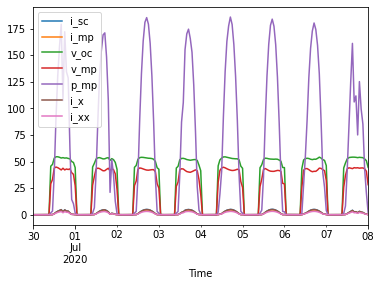

In [23]:
# This plot shows the results of the DC model (I assume the y-axis units are W, but I'm not sure).
mc.dc.plot()

/Users/jeffreysward/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python/pvlib/modelchain.py:499: pvlibDeprecationWarning: ModelChain.ac is deprecated and will be removed in v0.10. Use ModelChain.results.ac instead
  warnings.warn(msg, pvlibDeprecationWarning)


<AxesSubplot:xlabel='Time'>

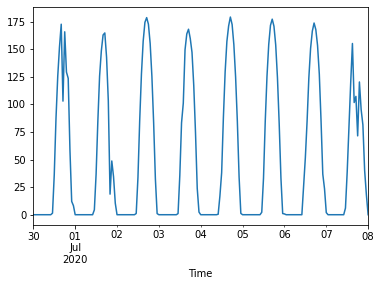

In [24]:
# This plot shows the AC power output (I assume the y-axis units are W, but I'm not sure).
# I reason this based on the fact the the module is rated to 220W, and the example here is for Jan 25.
mc.ac.plot()

## Nameplate Capacity-Based Power Calculation

/Users/jeffreysward/Box Sync/01_Research/01_Renewable_Analysis/WRF_Solar_and_Wind/pvlib-python/pvlib/modelchain.py:499: pvlibDeprecationWarning: ModelChain.ac is deprecated and will be removed in v0.10. Use ModelChain.results.ac instead
  warnings.warn(msg, pvlibDeprecationWarning)


<AxesSubplot:xlabel='Time'>

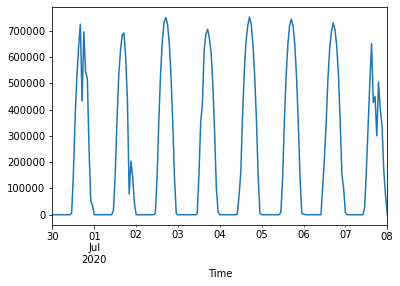

In [25]:
# We now scale the above profile based upon the total nameplate capacity
totalnameplatewdc = 923.9800 * 1000  # convert from kWdc to Wdc
ac_power = mc.ac/220 * totalnameplatewdc
ac_power.plot() # Note that this plot is in Watts